<a href="https://colab.research.google.com/github/subham73/Image-Captioning/blob/main/withoutAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#location of the data |
data_location =  "/content/drive/MyDrive/Datasets"
!ls $data_location

captions.txt  flickr8k.zip  Images


In [3]:
#reading the caption data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(5)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


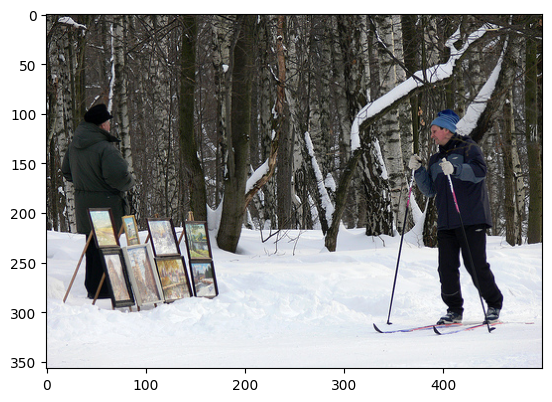

Caption: A man skis past another man displaying paintings in the snow .
Caption: A person wearing skis looking at framed pictures set up in the snow .
Caption: A skier looks at framed pictures in the snow next to trees .
Caption: Man on skis looking at artwork for sale in the snow
Caption: A collage of one person climbing a cliff .


In [4]:
#viewing the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#a image has 5 caption, so indx as: 1,6,11,16...
data_idx = 56

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

In [5]:
#vocabulary
import spacy
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place, to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', ',', 'to', 'find', 'a', 'city']

In [6]:
from collections import Counter
class Vocabulary:
    def __init__(self, freq_threshold):
        #setting the pre-reserved tokens 
        #int to string tokens
        self.intTostr = {0:"<PAD>", 
                     1:"<SOS>", 
                     2:"<EOS>", 
                     3:"<UNK>"}
        
        #string to int tokens
        self.strToint = {v:k for k,v in self.intTostr.items()}
        #minimum frequency reqd to be part of vocab
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.intTostr)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4 #index for intTostr
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.strToint[word] = idx
                    self.intTostr[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word 
            form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.strToint[token] 
                if token in self.strToint 
                else self.strToint["<UNK>"] 
                for token in tokenized_text ]    

In [7]:
#testing the vocab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to , find a city good"])
print(v.strToint)
print(v.numericalize("This is a good place to find a good city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, ',': 10, 'find': 11, 'city': 12}
[4, 5, 6, 7, 8, 9, 11, 6, 7, 12, 3, 3, 3]


In [8]:
import os
import torch

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

In [9]:
#setting up the device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
#seting up the pytorch dataset
class Flickr8kDataset(Dataset):
    """
    Flickr8kDataset
    """
    def __init__(self, image_file, captions_file, transform=None, 
                  freq_threshold=5):
        self.image_file = image_file
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.image_file,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.strToint["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.strToint["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [11]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  Flickr8kDataset(
    image_file = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)

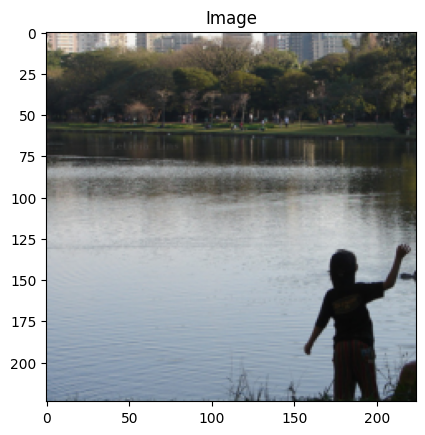

Token: tensor([  1,   4,  28,  16,   4,  80,  34,  19, 766, 163,   8,   4, 250, 215,
          5,   2])
Sentence:
['<SOS>', 'a', 'child', 'and', 'a', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'a', 'big', 'city', '.', '<EOS>']


In [13]:
#example Flicker8kDataset
img, caps = dataset[80]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.intTostr[token] for token in caps.tolist()])

In [14]:
class generate_batch_captions:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [15]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 128
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.strToint["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=generate_batch_captions(pad_idx=pad_idx,batch_first=True)
)

In [16]:
resnet = models.resnet50()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## **Encoder**

In [17]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1] # everythin except last fcl
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        

    def forward(self, images):
        features = self.resnet(images)                #(batch_size,2048,1,1)
        features = features.view(features.size(0), -1)#(batch_size,2048)
        features = self.embed(features)               #(batch_size,embed_size)
        return features

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers = 1):
        super().__init__()
        
        #save the model param
        # self.vocab_size = vocab_size
        # self.attention_dim = attention_dim
        # self.decoder_dim = decoder_dim
        
        # generate embeddings for words
        self.embedding = nn.Embedding(vocab_size,embed_size)
        #this embed takes one hot vector and generates lower dimensional embedding
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers = num_layers, 
                                batch_first = True)
        self.fcn = nn.Linear(hidden_size, vocab_size)


    def forward(self, features, captions):
      #Caption shape [batch_size, longest_text_in_batch]
      #Embedding shape [batch_size, longest_text_in_batch]
      #each word is represented using embedding of embed_size
      embeds = self.embedding(captions[: , :-1])

      #x shape [batch_size, longest_text_in_batch + 1, embedsize]
      #The first input to the decoder is the ecoder output
      x = torch.cat((features.unsqueeze(1), embeds), dim = 1)

      x, _ = self.lstm(x)
      x  = self.fcn(x)
      return x
    def generate_caption(self, inputs, hidden = None, max_len = 20, vocab = None):
      batch_size = inputs.size(0)
      captions = []

      for i in range(max_len):
        output, hidden = self.lstm(inputs, hidden)
        output = self.fcn(output)
        output = output.view(batch_size, -1)

        predicted_word_idx = output.argmax(dim = 1)
        captions.append(predicted_word_idx.item())

        if vocab.intTostr[predicted_word_idx.item()] == "<EOS>":
          break
        
        inputs = self.embedding(predicted_word_idx.unsqueeze(0))
      return [vocab.get_intTostr()[idx] for idx in captions]



In [21]:
def generate_caption(self, inputs, hidden = None, max_len = 20, vocab = None):
  batch_size = inputs.size(0)
  captions = []

  for i in range(max_len):
    output, hidden = self.lstm(inputs, hidden)
    output = self.fcn(output)
    output = output.view(batch_size, -1)

    predicted_word_idx = output.argmax(dim = 1)
    captions.append(predicted_word_idx.item())

    if vocab.intTostr[predicted_word_idx.item()] == "<EOS>":
      break
    
    inputs = self.embedding(predicted_word_idx.unsqueeze(0))
  return [vocab.get_intTostr()[idx] for idx in captions]


In [22]:
class Image2Caption(nn.Module):
  def __init__(self, emb_size, hidden_size, vocab_size, num_layers= 1):
    super().__init__()
    self.encoder = EncoderCNN(emb_size)
    self.decoder = DecoderRNN(emb_size, hidden_size, vocab_size, num_layers)

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)

    return outputs


In [23]:
emb_size = 100
hidden_size = 512
vocab_size = len(dataset.vocab)

num_layers = 2
learning_rate = 0.0001

In [24]:
# Seq2Seq model initialization

model = Image2Caption(emb_size, hidden_size, vocab_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.strToint["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 281MB/s]


In [25]:
# helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':emb_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':None,
        # 'encoder_dim':encoder_dim,
        # 'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'base1.pth')

In [27]:
num_epochs = 10
print_every = 1

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        # targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} Batch: {} loss: {:.5f}".format(epoch, idx+1, loss.item()))
        
    #generate the caption and display it
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)

    model.train()

    #save the latest model after every epoch
    save_model(model, epoch)

Epoch: 1 Batch: 1 loss: 7.87625
Epoch: 1 Batch: 2 loss: 7.85554
Epoch: 1 Batch: 3 loss: 7.83215
Epoch: 1 Batch: 4 loss: 7.80973
Epoch: 1 Batch: 5 loss: 7.77267
Epoch: 1 Batch: 6 loss: 7.73022
Epoch: 1 Batch: 7 loss: 7.65115
Epoch: 1 Batch: 8 loss: 7.58729
Epoch: 1 Batch: 9 loss: 7.46152
Epoch: 1 Batch: 10 loss: 7.34083
Epoch: 1 Batch: 11 loss: 7.18341
Epoch: 1 Batch: 12 loss: 7.02189
Epoch: 1 Batch: 13 loss: 6.86590
Epoch: 1 Batch: 14 loss: 6.66551
Epoch: 1 Batch: 15 loss: 6.44136
Epoch: 1 Batch: 16 loss: 6.38378
Epoch: 1 Batch: 17 loss: 6.23129
Epoch: 1 Batch: 18 loss: 6.13510
Epoch: 1 Batch: 19 loss: 5.96484
Epoch: 1 Batch: 20 loss: 5.88925
Epoch: 1 Batch: 21 loss: 5.76984
Epoch: 1 Batch: 22 loss: 5.65612
Epoch: 1 Batch: 23 loss: 5.63222
Epoch: 1 Batch: 24 loss: 5.56438
Epoch: 1 Batch: 25 loss: 5.53671
Epoch: 1 Batch: 26 loss: 5.51889
Epoch: 1 Batch: 27 loss: 5.38079
Epoch: 1 Batch: 28 loss: 5.40546
Epoch: 1 Batch: 29 loss: 5.31445
Epoch: 1 Batch: 30 loss: 5.28799
Epoch: 1 Batch: 31 

RuntimeError: ignored